32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Silhouette Score for Latent Features: 0.7820
Threshold used for anomaly detection: 0.014310427383514701
Anomaly detection output saved at: /kaggle/working/anomaly_detection_output.csv
Fraud explanations saved at: /kaggle/working/fraud_explanations.csv


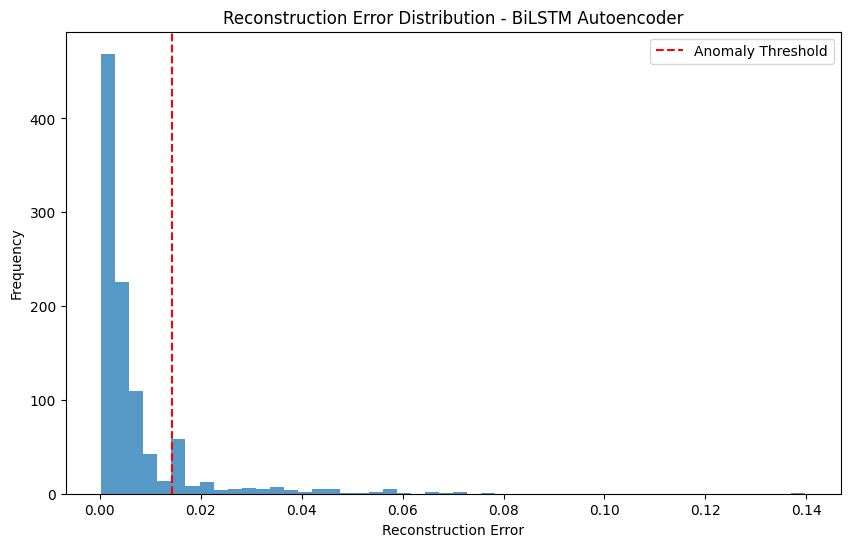

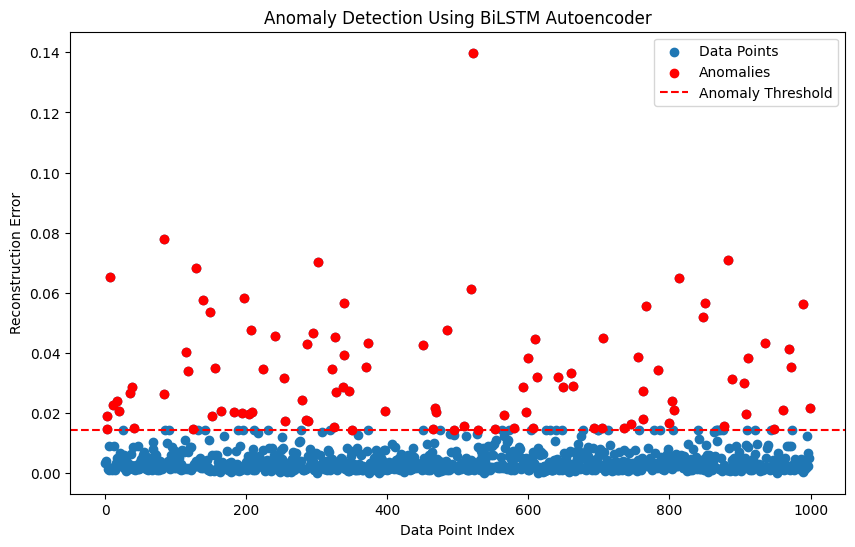

Fraudulent profiles data saved to: /kaggle/working/fraudulent_profiles.csv
Normalized skill data saved to: /kaggle/working/normalized_skill_data.csv


In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import spacy
import re

#Input Files
data_file_path = '/kaggle/input/train-data/Input_data.csv'  # Replace with the actual path for the file "input data"
connections_data = pd.read_csv('/kaggle/input/recommendations/Reciprocal_Recommendations.csv')  # Replace with the path of the file "reciprocative recommendations"

# Load a pre-trained spaCy model for Named Entity Recognition (NER)
nlp = spacy.load('en_core_web_sm')

# Load the combined data (file containing required columns for both tasks)

data = pd.read_csv(data_file_path)

# Verify that the required columns are present
required_columns = [
    'id', 'superlative_score', 'text_inconsistency_score', 'reciprocity_score',
    'Experience', 'Education'
]
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing in the data: {missing_columns}")

# ========================
# Part 1: Fraud Detection
# ========================

# Extract necessary columns for fraud detection
profile_id = data['id'].values
superlative_score = data['superlative_score'].values
text_inconsistency_score = data['text_inconsistency_score'].values
reciprocity_score = data['reciprocity_score'].values

# Load the recommendation connections CSV
connections_data = pd.read_csv('/kaggle/input/recommendations/Reciprocal_Recommendations.csv')  # Modify the path as needed

# Combine features
combined_features = np.vstack((
    reciprocity_score,
    text_inconsistency_score,
    superlative_score
)).T

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(combined_features)

# Calculate the inverse cumulative feature scale
inverse_cumulative_feature_scale = -np.sum(features_scaled, axis=1)

# Reshape data for BiLSTM input (samples, timesteps, features)
features_scaled = np.expand_dims(features_scaled, axis=1)

# BiLSTM Autoencoder Model
latent_dim = 2  # Dimensionality of the latent space

# Encoder
input_layer = Input(shape=(features_scaled.shape[1], features_scaled.shape[2]))
encoded = Bidirectional(LSTM(64, activation='relu', return_sequences=False))(input_layer)
latent_features = Dense(latent_dim, name='latent_features')(encoded)

# Decoder
decoded = RepeatVector(features_scaled.shape[1])(latent_features)
decoded = Bidirectional(LSTM(64, activation='relu', return_sequences=True))(decoded)
output_layer = TimeDistributed(Dense(features_scaled.shape[2]))(decoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
encoder = Model(inputs=input_layer, outputs=latent_features)  # For extracting latent features

# Compile the model with reconstruction loss
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
autoencoder.fit(
    features_scaled,
    features_scaled,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    verbose=0  # Set to 1 to see training progress
)

# Use the autoencoder to reconstruct the features
reconstructed = autoencoder.predict(features_scaled)

# Calculate the reconstruction error
reconstruction_error = np.mean(np.abs(features_scaled - reconstructed), axis=(1, 2))

# Set a dynamic threshold based on the 90th percentile of the reconstruction error
threshold = np.percentile(reconstruction_error, 90)
anomalies = reconstruction_error > threshold

# Extract latent features using the encoder
latent_features_output = encoder.predict(features_scaled)

# Apply K-Means clustering on the latent features
n_clusters = 2  # Assuming two clusters: normal and anomalies
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(latent_features_output)

# Calculate the silhouette score using the K-Means cluster labels
silhouette_avg = silhouette_score(latent_features_output, cluster_labels)
print(f'Silhouette Score for Latent Features: {silhouette_avg:.4f}')

# Determine the dominant factor for each profile
def find_dominant_factor(row):
    scores = {
        'reciprocity_score': row['reciprocity_score'],
        'text_inconsistency_score': row['text_inconsistency_score'],
        'superlative_score': row['superlative_score']
    }
    dominant_factor = max(scores, key=scores.get)
    return dominant_factor

# Combine data into a DataFrame
output_data = pd.DataFrame({
    'profile_id': profile_id,
    'reciprocity_score': reciprocity_score,
    'text_inconsistency_score': text_inconsistency_score,
    'superlative_score': superlative_score,
    'inverse_cumulative_feature_scale': inverse_cumulative_feature_scale,
    'reconstruction_error': reconstruction_error,
    'Fraud': anomalies
})

# Add the threshold as a separate column (same value for all rows)
output_data['threshold'] = threshold

# Determine the dominant factor for each profile
output_data['dominant_factor'] = output_data.apply(find_dominant_factor, axis=1)

# Generate fraud explanation prompts for profiles where fraud is detected
fraud_prompts = []
for index, row in output_data.iterrows():
    if row['Fraud']:
        profile_id = row['profile_id']
        
        # Handle reciprocity_score dominant factor
        if row['dominant_factor'] == 'reciprocity_score':
            # Find the connection in the additional CSV
            connected_profile = connections_data[connections_data['Person_A'] == profile_id]['Person_B'].values
            if len(connected_profile) > 0:
                connected_id = connected_profile[0]
                prompt = f"The profile with ID {profile_id} is flagged as fraud due to reciprocal recommendations with ID {connected_id}. Such patterns often indicate coordinated efforts to falsely boost credibility."
                fraud_prompts.append({'profile_id': profile_id, 'fraud_reason': prompt})
        
        # Handle superlative_score dominant factor
        elif row['dominant_factor'] == 'superlative_score':
            # Check for similar text_inconsistency and superlative scores
            if np.isclose(row['text_inconsistency_score'], row['superlative_score'], atol=0.05):
                prompt = f"The profile with ID {profile_id} is flagged as fraud due to inconsistencies in their career timeline. Similarity in text inconsistency and superlative usage suggests potential exaggeration of career events."
            else:
                prompt = f"The profile with ID {profile_id} is flagged as fraud due to excessive use of superlative terms in their recommendation letters. This may indicate an attempt to exaggerate qualifications or achievements."
            fraud_prompts.append({'profile_id': profile_id, 'fraud_reason': prompt})

        # Handle text_inconsistency_score dominant factor
        elif row['dominant_factor'] == 'text_inconsistency_score':
            # Check for similar text_inconsistency and superlative scores
            if np.isclose(row['text_inconsistency_score'], row['superlative_score'], atol=0.05):
                prompt = f"The profile with ID {profile_id} is flagged as fraud due to inconsistencies in their career timeline. Similarity in text inconsistency and superlative usage suggests potential exaggeration of career events."
            else:
                prompt = f"The profile with ID {profile_id} is flagged as fraud due to inconsistencies in the text of their recommendation letters. This may indicate conflicting information or an attempt to mislead."
            fraud_prompts.append({'profile_id': profile_id, 'fraud_reason': prompt})

# Save the fraud prompts to a new CSV
fraud_prompts_df = pd.DataFrame(fraud_prompts)
fraud_prompts_df.to_csv('/kaggle/working/fraud_explanations.csv', index=False)

# Save the main output data to a CSV
# output_csv_path = '/kaggle/working/anomaly_detection_output.csv'
# output_data.to_csv(output_csv_path, index=False)

print(f'Threshold used for anomaly detection: {threshold}')
print(f'Anomaly detection output saved at: {output_csv_path}')
print(f'Fraud explanations saved at: /kaggle/working/fraud_explanations.csv')

# Visualization of Reconstruction Error
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.75)
plt.axvline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.title('Reconstruction Error Distribution - BiLSTM Autoencoder')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Highlight anomalies in a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(range(len(reconstruction_error)), reconstruction_error, label='Data Points')
plt.scatter(np.where(anomalies)[0], reconstruction_error[anomalies], color='r', label='Anomalies')
plt.axhline(threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.title('Anomaly Detection Using BiLSTM Autoencoder')
plt.xlabel('Data Point Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()

# ===============================
# Part 2: Skill Extraction & Ranking
# ===============================

# Merge fraud detection results into the main data
data = data.merge(
    output_data[['profile_id', 'Fraud', 'dominant_factor']],
    left_on='id',
    right_on='profile_id',
    how='left'
)

# Drop the redundant 'profile_id' column
data.drop(columns=['profile_id'], inplace=True)

# Fill NaN values in 'Fraud' column with False (assuming NaN means not fraudulent)
data['Fraud'] = data['Fraud'].fillna(False)

# Step 1: Collect all unique skills across the entire dataset
def extract_skills(text):
    doc = nlp(text.lower())
    extracted_skills = set()
    
    for ent in doc.ents:
        # Consider entities that might represent skills
        if ent.label_ in ['ORG', 'PRODUCT', 'SKILL']:
            extracted_skills.add(ent.text)
    
    # Use regex to extract simple alphanumeric words that might represent skills
    extracted_skills.update(re.findall(r'\b[a-z]+\b', text.lower()))
    return extracted_skills

# Initialize a set to collect all unique skills from the entire dataset
all_unique_skills = set()

# Define the text columns for skill extraction
text_columns = ['Experience', 'Education']  # Adjust according to your data

# Gather all unique skills in the dataset
for index, row in data.iterrows():
    combined_text = ' '.join(str(row[col]) for col in text_columns if pd.notna(row[col]))
    skills = extract_skills(combined_text)
    all_unique_skills.update(skills)

# Convert all_unique_skills to lowercase to ensure case-insensitive matching
all_unique_skills = set(skill.lower() for skill in all_unique_skills)

# Step 2: For each profile, count how many of these unique skills they possess
skill_sets = []
skill_counts = []

# Iterate over profiles to count the number of skills for each
for index, row in data.iterrows():
    combined_text = ' '.join(str(row[col]) for col in text_columns if pd.notna(row[col]))
    profile_words = set(re.findall(r'\b[a-z]+\b', combined_text.lower()))  # Extract words
    matched_skills = all_unique_skills.intersection(profile_words)  # Find matching skills

    skill_sets.append(', '.join(sorted(matched_skills)))
    skill_counts.append(len(matched_skills))

# Add the skill count and skill set columns to the DataFrame
data['Skill_Count'] = skill_counts
data['Skill_Set'] = skill_sets

# Normalize the skill count using MinMaxScaler
scaler = MinMaxScaler()
data['Normalized_Skill_Count'] = scaler.fit_transform(data[['Skill_Count']])

# Set the 'Normalized_Skill_Count' to zero for fraud candidates
data.loc[data['Fraud'] == True, 'Normalized_Skill_Count'] = 0

# =========================
# Output CSV Files
# =========================

# First CSV: Data about fraudulent candidates
fraud_data = data[data['Fraud'] == True][['id', 'Fraud', 'dominant_factor']]

# Merge with fraud explanations to include the reasons
fraud_data = fraud_data.merge(
    fraud_prompts_df,
    left_on='id',
    right_on='profile_id',
    how='left'
)

# Drop redundant 'profile_id' column
fraud_data.drop(columns=['profile_id'], inplace=True)

# Save the fraudulent profiles data to CSV
fraud_output_path = '/kaggle/working/fraudulent_profiles.csv'
fraud_data.to_csv(fraud_output_path, index=False)

# Second CSV: Normalized skill data, sorted in descending order
skill_data = data[['id', 'Normalized_Skill_Count']].copy()
skill_data = skill_data.sort_values(by='Normalized_Skill_Count', ascending=False)

# Save the skill data to CSV
skill_output_path = '/kaggle/working/normalized_skill_data.csv'
skill_data.to_csv(skill_output_path, index=False)

print(f"Fraudulent profiles data saved to: {fraud_output_path}")
print(f"Normalized skill data saved to: {skill_output_path}")
